In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Libraries loaded successfully")

Libraries loaded successfully


In [51]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
# Load datasets
data_path = "/content/gdrive/MyDrive/Dalberg Data Fellow Case Study"

# Read datasets
facilities_raw = pd.read_excel(data_path + "/ehealth-kenya-facilities-download-21102015.xlsx")
population_raw = pd.read_csv(data_path + "/population-houseshold-data.csv", skiprows=6)

print("Overview of the datasets")
print("-"*40)
print(f"Health facilities dataset: {facilities_raw.shape}")
print(f"Population dataset: {population_raw.shape}")
print(f"\nTotal facilities in Kenya: {len(facilities_raw):,}")
print(f"Counties covered: {len(population_raw)}")

Overview of the datasets
----------------------------------------
Health facilities dataset: (10505, 50)
Population dataset: (48, 4)

Total facilities in Kenya: 10,505
Counties covered: 48


In [53]:
# Clean column names
facilities_raw.columns = facilities_raw.columns.str.strip().str.replace(" ", "_").str.upper()
population_raw.columns = population_raw.columns.str.strip().str.replace(" ", "_").str.upper()

# Filter for Nairobi only
facilities = facilities_raw[facilities_raw["COUNTY"].str.contains("Nairobi", case=False, na=False)].copy()
population = population_raw[population_raw["NAME"].str.contains("Nairobi", case=False, na=False)].copy()

print("Overview of Nairobi dataset")
print(f"Nairobi healthcare facilities: {len(facilities)}")
print(f"Nairobi population records: {len(population)}")

# Basic data cleaning
facilities["BEDS"] = facilities["BEDS"].fillna(0).astype(int)
facilities["COTS"] = facilities["COTS"].fillna(0).astype(int)

Overview of Nairobi dataset
Nairobi healthcare facilities: 942
Nairobi population records: 1


In [54]:
# Extract key demographic metrics
total_facilities = len(facilities)
total_beds = facilities["BEDS"].sum()
nairobi_pop = int(population["POPULATION"].iloc[0])
nairobi_households = int(population["NO.OF_HOUSEHOLDS"].iloc[0])
avg_household_size = float(population["AVG_HOUSEHOLD_SIZE"].iloc[0])

# Healthcare infrastructure summary
infrastructure_summary = pd.DataFrame({
    "Metric": [
        "Total Healthcare Facilities",
        "Total Hospital Beds",
        "Population Served",
        "Number of Households",
        "Average Household Size",
        "Facilities per 100K Population",
        "Beds per 1,000 Population",
        "Households per Facility",
        "People per Facility"
    ],
    "Current_Value": [
        f"{total_facilities:,}",
        f"{total_beds:,}",
        f"{nairobi_pop:,}",
        f"{nairobi_households:,}",
        f"{avg_household_size}",
        f"{total_facilities/nairobi_pop*100000:.1f}",
        f"{total_beds/nairobi_pop*1000:.2f}",
        f"{nairobi_households/total_facilities:.0f}",
        f"{nairobi_pop/total_facilities:.0f}"
    ],
    "Context": [
        "943 facilities serving 4.3M people",
        "Mix of primary care and hospital beds",
        "2019 census data",
        "From national census",
        "Nairobi average",
        "Facility accessibility indicator",
        "Hospital capacity indicator",
        "Community coverage metric",
        "Population accessibility ratio"
    ]
})

print("Healthcare Infrastructure Summary")
print("-"*40)
display(infrastructure_summary)

Healthcare Infrastructure Summary
----------------------------------------


,Metric,Current_Value,Context
0,Total Healthcare Facilities,942,943 facilities serving 4.3M people
1,Total Hospital Beds,"7,336",Mix of primary care and hospital beds
2,Population Served,"4,337,080",2019 census data
3,Number of Households,"1,506,888",From national census
4,Average Household Size,29.0,Nairobi average
5,Facilities per 100K Population,21.7,Facility accessibility indicator
6,"Beds per 1,000 Population",1.69,Hospital capacity indicator
7,Households per Facility,1600,Community coverage metric
8,People per Facility,4604,Population accessibility ratio


In [55]:
# Service availability analysis
print("Service Availability Analysis")
print("-"*50)

# Available health services in the dataset
all_services = ["ANC", "ART", "BEOC", "BLOOD", "CAES_SEC", "CEOC", "C-IMCI",
                "EPI", "FP", "GROWM", "HBC", "HCT", "IPD", "OPD", "OUTREACH",
                "PMTCT", "RAD/XRAY", "RHTC/RHDC", "TB_DIAG", "TB_LABS",
                "TB_TREAT", "YOUTH"]

service_data = {}
services_available = []

for service in all_services:
    if service in facilities.columns:
        # Handle both "Y" and numeric coding
        count_y = (facilities[service] == "Y").sum()
        count_1 = (facilities[service] == 1).sum()
        count = max(count_y, count_1)

        if count > 0:
            percentage = count / total_facilities * 100
            service_data[service] = {
                "count": count,
                "percentage": round(percentage, 1)
            }

            services_available.append({
                "Service": service,
                "Facilities_Offering": count,
                "Coverage_Percentage": round(percentage, 1),
                "Households_Without_Access": int(nairobi_households * (100 - percentage) / 100)
            })

# Create service availability dataframe
service_df = pd.DataFrame(services_available)
service_df = service_df.sort_values("Coverage_Percentage", ascending=False)

print(f"Services with available data: {len(services_available)} out of {len(all_services)}")
display(service_df)

Service Availability Analysis
--------------------------------------------------
Services with available data: 5 out of 22


,Service,Facilities_Offering,Coverage_Percentage,Households_Without_Access
4,IPD,297,31.5,1031786
2,FP,280,29.7,1058980
3,HBC,250,26.5,1106970
0,ART,109,11.6,1332524
1,C-IMCI,72,7.6,1391711


In [56]:
# SDG 3 categorization and analysis
print("SDG 3 Healthcare Analysis")
print("-"*45)

# Group services by SDG 3 targets
sdg3_categories = {
    "Maternal & Reproductive Health": ["ANC", "PMTCT", "FP", "BEOC", "CEOC"],
    "Child Health": ["EPI", "C-IMCI", "GROWM"],
    "Infectious Disease Control": ["TB_DIAG", "TB_TREAT", "TB_LABS", "HCT", "ART"],
    "Primary Healthcare": ["OPD", "HBC", "OUTREACH"],
    "Emergency & Specialized Care": ["IPD", "RAD/XRAY", "BLOOD", "CAES_SEC"],
    "Youth & Community Health": ["YOUTH", "RHTC/RHDC"]
}

sdg_analysis = []
for category, services in sdg3_categories.items():
    available_services = [s for s in services if s in service_data]

    if available_services:
        total_coverage = sum([service_data[s]["percentage"] for s in available_services])
        avg_coverage = total_coverage / len(available_services)
        total_facilities_offering = sum([service_data[s]["count"] for s in available_services])

        sdg_analysis.append({
            "SDG_3_Category": category,
            "Available_Services": len(available_services),
            "Average_Coverage_%": round(avg_coverage, 1),
            "Total_Service_Points": total_facilities_offering,
            "Priority_Level": "Critical" if avg_coverage < 30 else "High" if avg_coverage < 70 else "Moderate"
        })

sdg_df = pd.DataFrame(sdg_analysis)
sdg_df = sdg_df.sort_values("Average_Coverage_%")

print("SDG 3 Service Category Analysis:")
display(sdg_df)

SDG 3 Healthcare Analysis
---------------------------------------------
SDG 3 Service Category Analysis:


,SDG_3_Category,Available_Services,Average_Coverage_%,Total_Service_Points,Priority_Level
1,Child Health,1,7.6,72,Critical
2,Infectious Disease Control,1,11.6,109,Critical
3,Primary Healthcare,1,26.5,250,Critical
0,Maternal & Reproductive Health,1,29.7,280,Critical
4,Emergency & Specialized Care,1,31.5,297,High


In [57]:
# Facility type distribution
facility_types = facilities["TYPE"].value_counts()
for ftype, count in facility_types.head(8).items():
    percentage = count/total_facilities*100

# Create summary tables
facility_summary = pd.DataFrame({
    "Type": facility_types.index[:8],
    "Count": facility_types.values[:8],
    "Percentage": [f"{x/total_facilities*100:.1f}%" for x in facility_types.values[:8]]
})

print(f"Facility Distribution Summary:")
display(facility_summary.head())

Facility Distribution Summary:


,Type,Count,Percentage
0,Medical Clinic,460,48.8%
1,Dispensary,199,21.1%
2,Health Centre,88,9.3%
3,VCT Centre (Stand-Alone),56,5.9%
4,Other Hospital,41,4.4%


In [58]:
# District level analysis
district_analysis = facilities.groupby("DISTRICT").agg({
    "FACILITY_CODE": "count",
    "BEDS": "sum",
    "TYPE": lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else "Mixed"
}).rename(columns={"FACILITY_CODE": "Total_Facilities"})

district_analysis["Beds_per_Facility"] = (district_analysis["BEDS"] / district_analysis["Total_Facilities"]).round(1)
district_analysis["Percentage_of_Total_Facilities"] = (district_analysis["Total_Facilities"] / total_facilities * 100).round(1)

district_analysis = district_analysis.sort_values("Total_Facilities", ascending=False)

print("District-Level Healthcare Distribution:")
display(district_analysis)

District-Level Healthcare Distribution:


,Total_Facilities,BEDS,TYPE,Beds_per_Facility,Percentage_of_Total_Facilities
DISTRICT,,,,,
Starehe,136,357,Medical Clinic,2.6,14.4
Kibra,93,1807,Medical Clinic,19.4,9.9
Roysambu,83,96,Medical Clinic,1.2,8.8
Dagoretti North,76,569,Medical Clinic,7.5,8.1
Westlands,72,633,Medical Clinic,8.8,7.6
Langata,61,723,Medical Clinic,11.9,6.5
Kamukunji,59,1083,Medical Clinic,18.4,6.3
Kasarani,58,177,Medical Clinic,3.1,6.2
Makadara,55,195,Medical Clinic,3.5,5.8


In [59]:
# Calculate household impact for key services
key_services = ["FP", "ART", "IPD", "HBC", "C-IMCI"]
household_impact = []

for service in key_services:
    if service in service_data:
        coverage = service_data[service]["percentage"]
        households_without = nairobi_households * (100 - coverage) / 100
        people_without = households_without * avg_household_size

        household_impact.append({
            "Service": service,
            "Service_Description": {
                "FP": "Family Planning",
                "ART": "HIV Treatment",
                "IPD": "Emergency/Inpatient Care",
                "HBC": "Home-Based Care",
                "C-IMCI": "Child Health Services"
            }.get(service, service),
            "Coverage_%": coverage,
            "Households_Without_Access": f"{households_without:,.0f}",
            "People_Affected": f"{people_without:,.0f}",
            "SDG_3_Priority": "Critical" if coverage < 30 else "High" if coverage < 70 else "Moderate"
        })

household_df = pd.DataFrame(household_impact)
household_df = household_df.sort_values("Coverage_%")

print("Household Access Gaps for Key Services:")
display(household_df)

Household Access Gaps for Key Services:


,Service,Service_Description,Coverage_%,Households_Without_Access,People_Affected,SDG_3_Priority
4,C-IMCI,Child Health Services,7.6,"1,392,365","40,378,571",Critical
1,ART,HIV Treatment,11.6,"1,332,089","38,630,581",Critical
3,HBC,Home-Based Care,26.5,"1,107,563","32,119,318",Critical
0,FP,Family Planning,29.7,"1,059,342","30,720,926",Critical
2,IPD,Emergency/Inpatient Care,31.5,"1,032,218","29,934,330",High


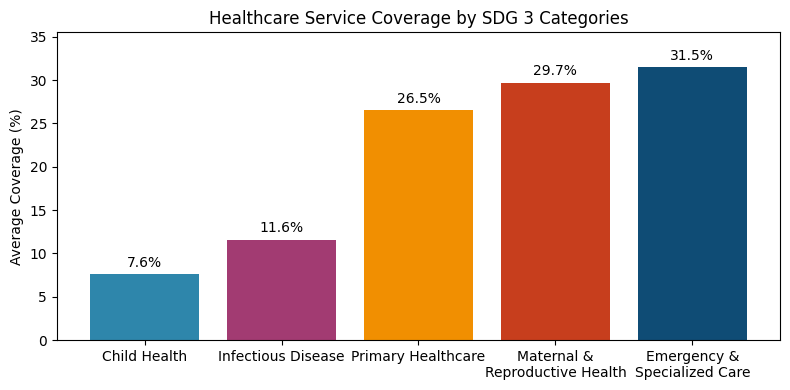

In [60]:
# Chart 1: service Coverage by SDG 3 Categories
plt.figure(figsize=(8, 4))

if len(sdg_df) > 0:
    # Category labels
    categories = [
        "Child Health",
        "Infectious Disease",
        "Primary Healthcare",
        "Maternal &\nReproductive Health",
        "Emergency &\nSpecialized Care"
    ]
    coverages = sdg_df["Average_Coverage_%"].head(5).values

    colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#0F4C75"]
    bars = plt.bar(range(len(categories)), coverages, color=colors[:len(categories)])

    plt.title("Healthcare Service Coverage by SDG 3 Categories", fontsize=12, fontweight="normal")
    plt.ylabel("Average Coverage (%)", fontsize=10)
    plt.xticks(range(len(categories)), categories, rotation=0, ha="center", fontsize=10)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f"{height:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="normal")

    # Fix the y-axis limit to accommodate labels
    plt.ylim(0, max(coverages) + 4)

plt.tight_layout()
plt.show()

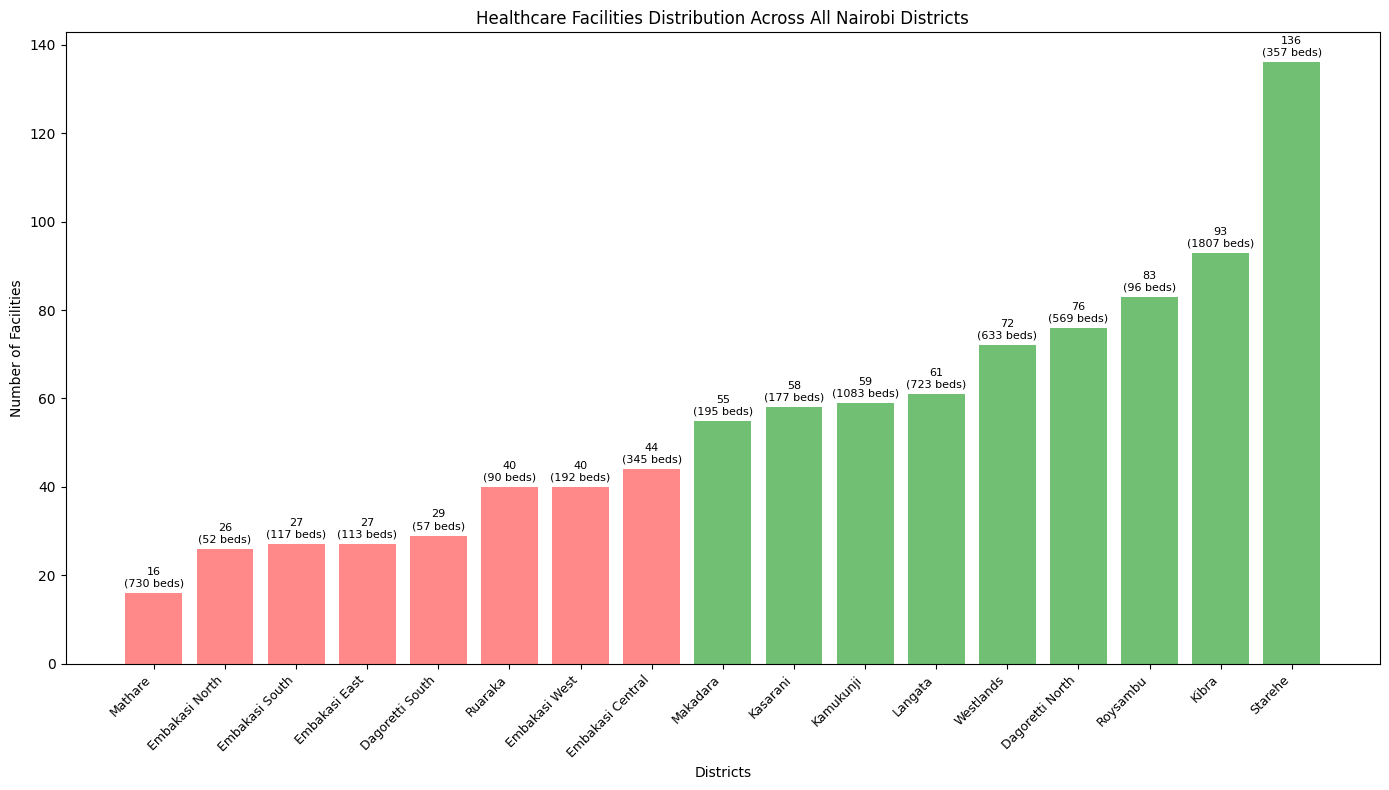

In [61]:
# Chart 2: All Districts Healthcare Distribution
plt.figure(figsize=(14, 8))

# All districts sorted by facility count
all_districts = district_analysis.sort_values("Total_Facilities", ascending=True)

bars = plt.bar(range(len(all_districts)), all_districts["Total_Facilities"],
               color=["#ff6b6b" if x < 50 else "#4CAF50" for x in all_districts["Total_Facilities"]],
               alpha=0.8)

plt.title("Healthcare Facilities Distribution Across All Nairobi Districts", fontsize=12)
plt.ylabel("Number of Facilities")
plt.xlabel("Districts")
plt.xticks(range(len(all_districts)), all_districts.index, rotation=45, ha="right", fontsize=9)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    beds = all_districts.iloc[i]["BEDS"]
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f"{int(height)}\n({beds} beds)", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

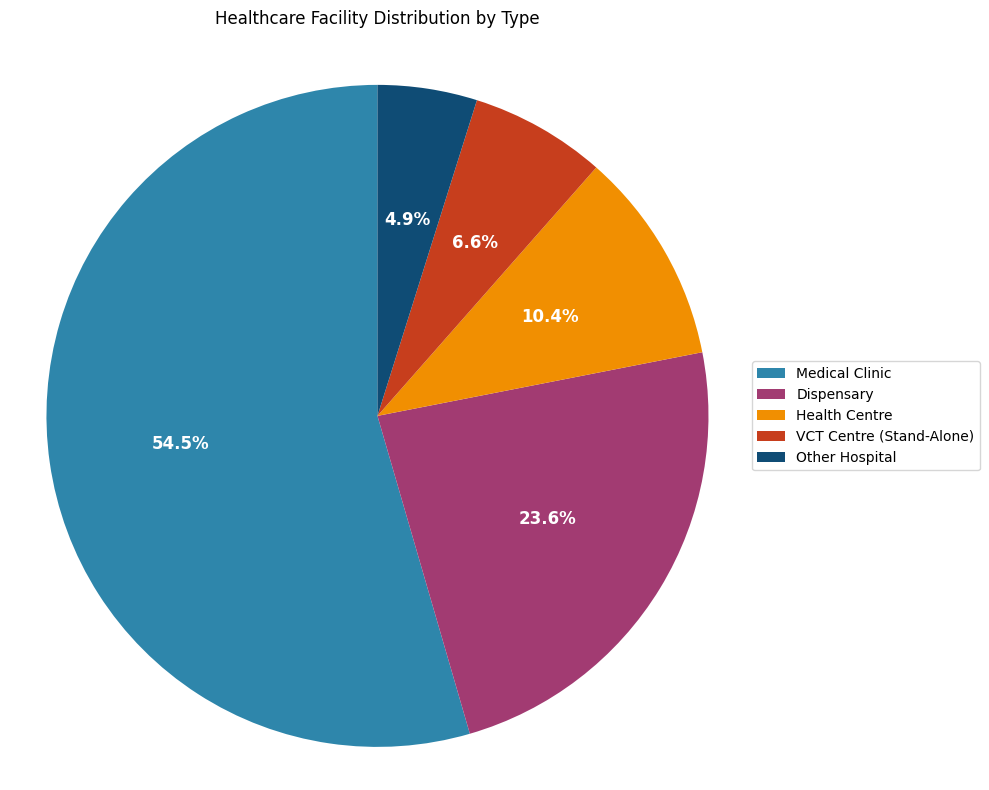

In [62]:
# Chart 3: Facility Type Distribution
plt.figure(figsize=(10, 8))

top_types = facility_types.head(5)

colors = ["#2E86AB", "#A23B72", "#F18F01", "#C73E1D", "#0F4C75", "#c2c2f0"]

# Create pie chart
plt.pie(top_types.values, labels=None, autopct='%1.1f%%',
        colors=colors[:len(top_types)], startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'white'})

plt.title("Healthcare Facility Distribution by Type", fontsize=12, fontweight="normal", pad=20)

# Add legend
plt.legend(top_types.index, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

# Spacing
plt.subplots_adjust(top=0.9)
plt.axis('equal')

plt.tight_layout()
plt.show()